In [1]:
from __future__ import print_function
import os
import nltk
import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import itertools
import vocabulary
import newsreader
import scipy
import sklearn
import os
from nltk.corpus import stopwords
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.metrics import jaccard_similarity_score
try:
    import cPickle as pickle
except:
    import pickle
from sklearn.datasets.twenty_newsgroups import \
     strip_newsgroup_header as strip_newsgroup_header
from sklearn.datasets.twenty_newsgroups import \
     strip_newsgroup_quoting as strip_newsgroup_quoting
from sklearn.datasets.twenty_newsgroups import \
     strip_newsgroup_footer as strip_newsgroup_footer
from sklearn.metrics.pairwise import linear_kernel
matplotlib.rcParams['figure.figsize'] = (10,10)

## Step1 - part(a):

Lets define our file path and take two articles which have similar

In [2]:
vocab_file, vocab_file_type = "reviews-vocab.pkl", "pickle"

embedding_file, embedding_dimensions, embedding_cache = "D:/Rutgers/4th-Semester/Natural_Language_Processing/glove.6B/glove.6B.50d.txt", 50, "newsgroup-embedding.npz"

all_data, train_dir, dev_dir, test_dir = "D:/Rutgers/4th-Semester/Natural_Language_Processing/Homework-1","D:/Rutgers/4th-Semester/Natural_Language_Processing/Homework-1/20news-bydate-train/", None ,"D:/Rutgers/4th-Semester/Natural_Language_Processing/Homework-1/20news-bydate-test/" 
    
class1, class2 = "comp.sys.ibm.pc.hardware", "comp.sys.mac.hardware"

has_bad_metadata = True

In [3]:
made_vocabulary = False
if made_vocabulary :
    v = vocabulary.Vocabulary.load(vocab_file, file_type=vocab_file_type)
else: 
    tokens = newsreader.all_textfile_tokens(all_data, strip_metadata=has_bad_metadata)                                            
    v = vocabulary.Vocabulary.from_iterable(tokens, file_type=vocab_file_type)
    v.save(vocab_file)
v.stop_growth()

In [4]:
made_embedding = False
if made_embedding :
    e = newsreader.load_sparse_csr(embedding_cache)
else: 
    e = newsreader.build_sparse_embedding(v, embedding_file, embedding_dimensions)
    newsreader.save_sparse_csr(embedding_cache, e)

140907 words were not in glove


In [5]:
targets = []
def selected(name) :
    if not targets:
        return True
    if any(t.startswith(name) for t in targets) :
        return True
    return False

In [6]:
def use_default_features(vocab) :
    return lambda data: vocab

def count_features(features, gen_tokens) :
    for t in gen_tokens :
        r = features.add(t)
        if r :
            yield r    
            
count_data = newsreader.DataManager(train_dir + class1,
                                       train_dir + class2,
                                       test_dir + class1,
                                       test_dir + class2,
                                       use_default_features(v),
                                       count_features,
                                       dev_dir + class1 if dev_dir else None,
                                       dev_dir + class2 if dev_dir else None,
                                       strip_metadata=has_bad_metadata)

count_data.initialize(build_cache=True)

In [7]:
def make_boolean_features(feature_counter) :
    def collect_features(features, gen_tokens) :
        seen = set()
        for f in feature_counter(features, gen_tokens) :
            seen.add(f)
        for f in seen :
            yield f
    return collect_features

boolean_data = newsreader.DataManager(train_dir + class1,
                                         train_dir + class2,
                                         test_dir + class1,
                                         test_dir + class2,
                                         use_default_features(v),
                                         make_boolean_features(count_features),
                                         dev_dir + class1 if dev_dir else None,
                                         dev_dir + class2 if dev_dir else None,
                                         strip_metadata=has_bad_metadata)

boolean_data.initialize(build_cache=True)

In [8]:
class Experiment(object) :
    '''Organize the process of getting data, building a classifier,
    and exploring new representations'''
    
    def __init__(self, data, comment, classifier, cdesc) :
        'set up the problem of learning a classifier from a data manager'
        self.data = data
        self.comment = comment
        self.classifier = classifier
        self.cdesc = cdesc
        self.initialized = False
        
    def initialize(self) :
        'materialize the training data, dev data and test data as matrices'
        if not self.initialized :
            self.train_X, self.train_y = self.data.training_data()
            self.dev_X, self.dev_y = self.data.dev_data()
            self.test_X, self.test_y = self.data.test_data()
            self.initialized = True
        
    def fit_and_validate(self, report=True) :
        'train the classifier and assess predictions on dev data'
        if not self.initialized :
            self.initialize()
        self.classifier.fit(self.train_X, self.train_y)
        self.dev_predictions = self.classifier.predict(self.dev_X)
        self.accuracy = sklearn.metrics.accuracy_score(self.dev_y, self.dev_predictions)
        if report :
            print("{}\nclassified by {}\naccuracy {}".format(self.comment, self.cdesc, self.accuracy))
            
    def xval(self, folds=20, report=True) :
        accuracies = []
        for i in range(folds) :
            self.fit_and_validate(report=False)
            accuracies.append(self.accuracy)
        if report :
            msg = "{}\nclassified by {}\naverage accuracy {} (std {})"
            print(msg.format(self.comment, self.cdesc, 
                             sum(accuracies)/folds,
                             np.std(accuracies)))
    
    @classmethod
    def transform(cls, expt, operation, description, classifier, cdesc) :
        'use operation to transform the data from expt and set up new classifier'
        if not expt.initialized :
            expt.initialize()
        result = cls(expt.data, expt.comment + '\n' + description, classifier, cdesc)
        result.train_X, result.train_y = operation(expt.train_X, expt.train_y, 'train')
        result.dev_X, result.dev_y = operation(expt.dev_X, expt.dev_y, 'dev')
        result.test_X, result.test_y = operation(expt.test_X, expt.test_y, 'test')
        result.initialized = True
        return result
        

In [9]:
if selected("expt_10_"):
    expt_10_ = Experiment(count_data,
                       "{}: {} vs {}, using word count features".format(all_data, class1, class2),
                       sklearn.linear_model.SGDClassifier(loss="log",
                                       penalty="elasticnet",
                                       max_iter=50),
                       "logistic regression")
    expt_10_.initialize()
    expt_10_.xval()

D:/Rutgers/4th-Semester/Natural_Language_Processing/Homework-1: comp.sys.ibm.pc.hardware vs comp.sys.mac.hardware, using word count features
classified by logistic regression
average accuracy 0.7859693877551021 (std 0.01609166202847976)


In [10]:
if selected("expt_11_") :
    expt_11_ = Experiment(boolean_data,
                         "{}: {} vs {}, using word presence/absence features".format(all_data, class1, class2),
                         sklearn.linear_model.SGDClassifier(loss="log",
                                       penalty="elasticnet",
                                       max_iter=50),
                         "logistic regression")
    expt_11_.initialize()
    expt_11_.xval()

D:/Rutgers/4th-Semester/Natural_Language_Processing/Homework-1: comp.sys.ibm.pc.hardware vs comp.sys.mac.hardware, using word presence/absence features
classified by logistic regression
average accuracy 0.8158163265306122 (std 0.014148392473328636)


We setup the experiment to look at two kinds of newsgroups we believe maybe matching. I considered newsgroups - **comp.sys.ibm.pc.hardware** and **comp.sys.mac.hardware**. Both these topics talk about computer hardware but about two different firms, I hypothesize the assumption that classifier may find it hard to explain the difference amongst them. We tried (word count features) vs (word presence/absence features) we  get 78.5% vs 81.58% accuracy on the test.

## Step1 - part(b):

In [11]:
class1, class2 = "soc.religion.christian", "rec.autos"

In [12]:
def use_default_features(vocab) :
    return lambda data: vocab

def count_features(features, gen_tokens) :
    for t in gen_tokens :
        r = features.add(t)
        if r :
            yield r    
            
count_data = newsreader.DataManager(train_dir + class1,
                                       train_dir + class2,
                                       test_dir + class1,
                                       test_dir + class2,
                                       use_default_features(v),
                                       count_features,
                                       dev_dir + class1 if dev_dir else None,
                                       dev_dir + class2 if dev_dir else None,
                                       strip_metadata=has_bad_metadata)

count_data.initialize(build_cache=True)

In [13]:
if selected("expt_10_"):
    expt_10_ = Experiment(count_data,
                       "{}: {} vs {}, using word count features".format(all_data, class1, class2),
                       sklearn.linear_model.SGDClassifier(loss="log",
                                       penalty="elasticnet",
                                       max_iter=50),
                       "logistic regression")
    expt_10_.initialize()
    expt_10_.xval()

D:/Rutgers/4th-Semester/Natural_Language_Processing/Homework-1: soc.religion.christian vs rec.autos, using word count features
classified by logistic regression
average accuracy 0.8876262626262627 (std 0.0104577167883074)


In [14]:
def make_boolean_features(feature_counter) :
    def collect_features(features, gen_tokens) :
        seen = set()
        for f in feature_counter(features, gen_tokens) :
            seen.add(f)
        for f in seen :
            yield f
    return collect_features

boolean_data = newsreader.DataManager(train_dir + class1,
                                         train_dir + class2,
                                         test_dir + class1,
                                         test_dir + class2,
                                         use_default_features(v),
                                         make_boolean_features(count_features),
                                         dev_dir + class1 if dev_dir else None,
                                         dev_dir + class2 if dev_dir else None,
                                         strip_metadata=has_bad_metadata)

boolean_data.initialize(build_cache=True)

In [15]:
if selected("expt_11_") :
    expt_11_ = Experiment(boolean_data,
                         "{}: {} vs {}, using word presence/absence features".format(all_data, class1, class2),
                         sklearn.linear_model.SGDClassifier(loss="log",
                                       penalty="elasticnet",
                                       max_iter=50),
                         "logistic regression")
    expt_11_.initialize()
    expt_11_.xval()

D:/Rutgers/4th-Semester/Natural_Language_Processing/Homework-1: soc.religion.christian vs rec.autos, using word presence/absence features
classified by logistic regression
average accuracy 0.8954545454545457 (std 0.012686723926343913)


The part(b) of this analysis takes into picture two disimilar newgroups and we compare their accuracy. They seem to perform well in comparison to the previous step. The accuracy of this model is **88.7% (word count features)** vs **89.5% (word absence/ presence features)**.

## Step2 - Lets measure document similarity

I am setting up an experiment to check newsgroup similarity and visualize this using some heat maps. I am assuming newsgroups which talk about religion to be similar, groups talking about technology also to be similar and etc. The least similar newsgroup I assume shall be 'misc.forsale'.

## Step3 - Setting up the experiment

We assume documents in every newsgroup as a large corpus. We split the words and apply tf-idf algorithm to it. Once this is done
a dot product between the two gives the cosine similarity between the newsgroup. Another method is to reduce the dimension
and check the similarity. Jaccard similarity was also taken into consideration, which measures the number of common words betwee, two documents.

## Step4 - Running the experiment

In [18]:
path = 'D:/Rutgers/4th-Semester/Natural_Language_Processing/20-Newsgroup/'

In [21]:
news_group_collection = dict()

for name in os.listdir(path):
    
    path_new = os.path.join(path, name)
    text_list =[]
    for fname in sorted(os.listdir(path_new)):
        path_fname = os.path.join(path_new, fname)
        with open(path_fname,encoding='latin-1') as f:
            text = f.read()
            text = strip_newsgroup_footer(
            strip_newsgroup_quoting(
            strip_newsgroup_header(text)))
            text = re.sub(r'[^\x00-\x7F]+', ' ', text)
            text = re.sub(r'\n\n',' ',text)
            text = re.sub(r'\n',' ',text)
            text_list.append(text)
    news_group_collection[name] = text_list     
            

In [22]:
news_group = dict()
news_data= []
for k,v in news_group_collection.items():
    str1 = ''.join(str(e) for e in v)
    news_data.append(str1)
    news_group[k] = str1

In [23]:
tfidf = TfidfVectorizer(stop_words='english').fit_transform(news_data)

In [24]:
cosine_similarities = linear_kernel(tfidf[0:20], tfidf)

In [25]:
cosine_similarities_dt = pd.DataFrame(cosine_similarities)

In [26]:
headers = list(news_group.keys())
print(headers)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [27]:
def ploting(data_st,X):
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.25,left=0.25)
    heatmap = ax.pcolor(data_st)
    cbar = plt.colorbar(heatmap)
    ax.set_xticks(np.arange(data_st.shape[1]) + 0.5, minor=False)
    ax.set_yticks(np.arange(data_st.shape[0]) + 0.5, minor=False)
    ax.set_xticklabels(headers,rotation=90)
    ax.set_yticklabels(headers)
    ax.set_title(X)
    plt.show()

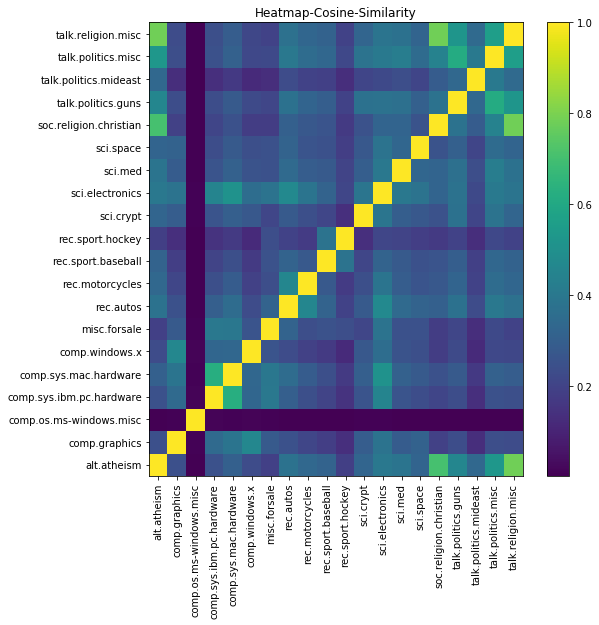

In [28]:
ploting(cosine_similarities_dt,'Heatmap-Cosine-Similarity')

In [29]:
def dimension_reduction(components,iterations):
    lsa = TruncatedSVD(n_components = components, algorithm = 'randomized', n_iter = iterations)
    dtm_lsa = lsa.fit_transform(tfidf)
    dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa)
    return dtm_lsa

In [30]:
dtm_lsa = dimension_reduction(10,5)

In [31]:
lsa_similarities = linear_kernel(dtm_lsa[0:20], dtm_lsa)

In [32]:
lsa_similarities_dt = pd.DataFrame(lsa_similarities)

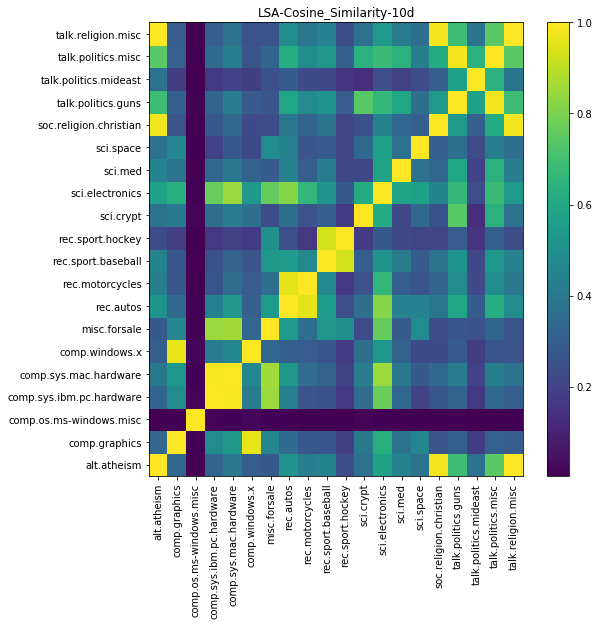

In [33]:
ploting(lsa_similarities_dt,'LSA-Cosine_Similarity-10d')

In [34]:
dtm_lsa = dimension_reduction(20,5)

In [35]:
lsa_similarities = linear_kernel(dtm_lsa[0:20], dtm_lsa)

In [36]:
lsa_similarities_dt = pd.DataFrame(lsa_similarities)

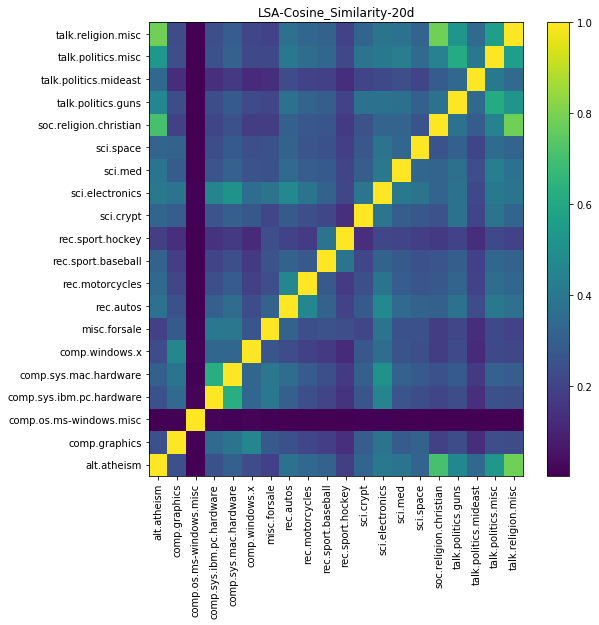

In [37]:
ploting(lsa_similarities_dt,'LSA-Cosine_Similarity-20d')

## Try finding all pairs of newsgroup with similarity (>.5):

In [240]:
cosine_sim_top = cosine_similarities_dt.applymap(lambda x : x if x > .5 else .49)

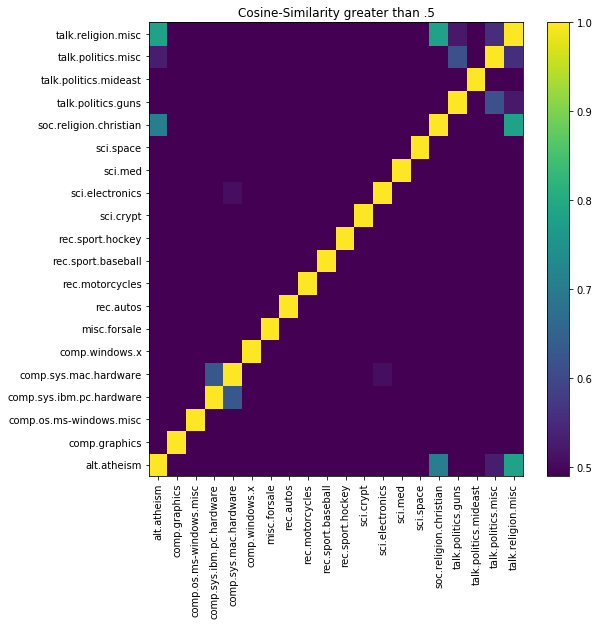

In [241]:
ploting(cosine_sim_top,'Cosine-Similarity greater than .5')

So we have heatmaps which of cosine similarity without dimension reduction.The plot does supoort our hypothesis to an extent matching newsgroups. We see similarity in terms of religion, sports, auto. However 'comp.misc.windows' seems to be poorly similar to all newgroup. I would be interested to see why this is happening. I shall explore more of this in my later analysis. On reducing dimensions using SVD, we are able to remove noise patterns from the data and the heatmap shows more similarity.Increasing the dimensions only leads to the heatmap being very similar to the cosine-similarity without dimension reduction.

## Jaccard Similarity

In [193]:
news_tokens = dict()
for k,v in news_group_collection.items():
    set_words = set()
    for i in range(len(v)):
        t = v[i].split()
        for words in t:
            if words not in stopwords.words('english'):
                set_words.add(words)
    news_tokens[k] = set_words

0 alt.atheism
1 alt.atheism
2 alt.atheism
3 alt.atheism
4 alt.atheism
5 alt.atheism
6 alt.atheism
7 alt.atheism
8 alt.atheism
9 alt.atheism
10 alt.atheism
11 alt.atheism
12 alt.atheism
13 alt.atheism
14 alt.atheism
15 alt.atheism
16 alt.atheism
17 alt.atheism
18 alt.atheism
19 alt.atheism
20 alt.atheism
21 alt.atheism
22 alt.atheism
23 alt.atheism
24 alt.atheism
25 alt.atheism
26 alt.atheism
27 alt.atheism
28 alt.atheism
29 alt.atheism
30 alt.atheism
31 alt.atheism
32 alt.atheism
33 alt.atheism
34 alt.atheism
35 alt.atheism
36 alt.atheism
37 alt.atheism
38 alt.atheism
39 alt.atheism
40 alt.atheism
41 alt.atheism
42 alt.atheism
43 alt.atheism
44 alt.atheism
45 alt.atheism
46 alt.atheism
47 alt.atheism
48 alt.atheism
49 alt.atheism
50 alt.atheism
51 alt.atheism
52 alt.atheism
53 alt.atheism
54 alt.atheism
55 alt.atheism
56 alt.atheism
57 alt.atheism
58 alt.atheism
59 alt.atheism
60 alt.atheism
61 alt.atheism
62 alt.atheism
63 alt.atheism
64 alt.atheism
65 alt.atheism
66 alt.atheism
67 al

524 alt.atheism
525 alt.atheism
526 alt.atheism
527 alt.atheism
528 alt.atheism
529 alt.atheism
530 alt.atheism
531 alt.atheism
532 alt.atheism
533 alt.atheism
534 alt.atheism
535 alt.atheism
536 alt.atheism
537 alt.atheism
538 alt.atheism
539 alt.atheism
540 alt.atheism
541 alt.atheism
542 alt.atheism
543 alt.atheism
544 alt.atheism
545 alt.atheism
546 alt.atheism
547 alt.atheism
548 alt.atheism
549 alt.atheism
550 alt.atheism
551 alt.atheism
552 alt.atheism
553 alt.atheism
554 alt.atheism
555 alt.atheism
556 alt.atheism
557 alt.atheism
558 alt.atheism
559 alt.atheism
560 alt.atheism
561 alt.atheism
562 alt.atheism
563 alt.atheism
564 alt.atheism
565 alt.atheism
566 alt.atheism
567 alt.atheism
568 alt.atheism
569 alt.atheism
570 alt.atheism
571 alt.atheism
572 alt.atheism
573 alt.atheism
574 alt.atheism
575 alt.atheism
576 alt.atheism
577 alt.atheism
578 alt.atheism
579 alt.atheism
580 alt.atheism
581 alt.atheism
582 alt.atheism
583 alt.atheism
584 alt.atheism
585 alt.atheism
586 alt.

38 comp.graphics
39 comp.graphics
40 comp.graphics
41 comp.graphics
42 comp.graphics
43 comp.graphics
44 comp.graphics
45 comp.graphics
46 comp.graphics
47 comp.graphics
48 comp.graphics
49 comp.graphics
50 comp.graphics
51 comp.graphics
52 comp.graphics
53 comp.graphics
54 comp.graphics
55 comp.graphics
56 comp.graphics
57 comp.graphics
58 comp.graphics
59 comp.graphics
60 comp.graphics
61 comp.graphics
62 comp.graphics
63 comp.graphics
64 comp.graphics
65 comp.graphics
66 comp.graphics
67 comp.graphics
68 comp.graphics
69 comp.graphics
70 comp.graphics
71 comp.graphics
72 comp.graphics
73 comp.graphics
74 comp.graphics
75 comp.graphics
76 comp.graphics
77 comp.graphics
78 comp.graphics
79 comp.graphics
80 comp.graphics
81 comp.graphics
82 comp.graphics
83 comp.graphics
84 comp.graphics
85 comp.graphics
86 comp.graphics
87 comp.graphics
88 comp.graphics
89 comp.graphics
90 comp.graphics
91 comp.graphics
92 comp.graphics
93 comp.graphics
94 comp.graphics
95 comp.graphics
96 comp.graphi

497 comp.graphics
498 comp.graphics
499 comp.graphics
500 comp.graphics
501 comp.graphics
502 comp.graphics
503 comp.graphics
504 comp.graphics
505 comp.graphics
506 comp.graphics
507 comp.graphics
508 comp.graphics
509 comp.graphics
510 comp.graphics
511 comp.graphics
512 comp.graphics
513 comp.graphics
514 comp.graphics
515 comp.graphics
516 comp.graphics
517 comp.graphics
518 comp.graphics
519 comp.graphics
520 comp.graphics
521 comp.graphics
522 comp.graphics
523 comp.graphics
524 comp.graphics
525 comp.graphics
526 comp.graphics
527 comp.graphics
528 comp.graphics
529 comp.graphics
530 comp.graphics
531 comp.graphics
532 comp.graphics
533 comp.graphics
534 comp.graphics
535 comp.graphics
536 comp.graphics
537 comp.graphics
538 comp.graphics
539 comp.graphics
540 comp.graphics
541 comp.graphics
542 comp.graphics
543 comp.graphics
544 comp.graphics
545 comp.graphics
546 comp.graphics
547 comp.graphics
548 comp.graphics
549 comp.graphics
550 comp.graphics
551 comp.graphics
552 comp.g

955 comp.graphics
956 comp.graphics
957 comp.graphics
958 comp.graphics
959 comp.graphics
960 comp.graphics
961 comp.graphics
962 comp.graphics
963 comp.graphics
964 comp.graphics
965 comp.graphics
966 comp.graphics
967 comp.graphics
968 comp.graphics
969 comp.graphics
970 comp.graphics
971 comp.graphics
972 comp.graphics
973 comp.graphics
974 comp.graphics
975 comp.graphics
976 comp.graphics
977 comp.graphics
978 comp.graphics
979 comp.graphics
980 comp.graphics
981 comp.graphics
982 comp.graphics
983 comp.graphics
984 comp.graphics
985 comp.graphics
986 comp.graphics
987 comp.graphics
988 comp.graphics
989 comp.graphics
990 comp.graphics
991 comp.graphics
992 comp.graphics
993 comp.graphics
994 comp.graphics
995 comp.graphics
996 comp.graphics
997 comp.graphics
998 comp.graphics
999 comp.graphics
0 comp.os.ms-windows.misc
1 comp.os.ms-windows.misc
2 comp.os.ms-windows.misc
3 comp.os.ms-windows.misc
4 comp.os.ms-windows.misc
5 comp.os.ms-windows.misc
6 comp.os.ms-windows.misc
7 comp.o

273 comp.os.ms-windows.misc
274 comp.os.ms-windows.misc
275 comp.os.ms-windows.misc
276 comp.os.ms-windows.misc
277 comp.os.ms-windows.misc
278 comp.os.ms-windows.misc
279 comp.os.ms-windows.misc
280 comp.os.ms-windows.misc
281 comp.os.ms-windows.misc
282 comp.os.ms-windows.misc
283 comp.os.ms-windows.misc
284 comp.os.ms-windows.misc
285 comp.os.ms-windows.misc
286 comp.os.ms-windows.misc
287 comp.os.ms-windows.misc
288 comp.os.ms-windows.misc
289 comp.os.ms-windows.misc
290 comp.os.ms-windows.misc
291 comp.os.ms-windows.misc
292 comp.os.ms-windows.misc
293 comp.os.ms-windows.misc
294 comp.os.ms-windows.misc
295 comp.os.ms-windows.misc
296 comp.os.ms-windows.misc
297 comp.os.ms-windows.misc
298 comp.os.ms-windows.misc
299 comp.os.ms-windows.misc
300 comp.os.ms-windows.misc
301 comp.os.ms-windows.misc
302 comp.os.ms-windows.misc
303 comp.os.ms-windows.misc
304 comp.os.ms-windows.misc
305 comp.os.ms-windows.misc
306 comp.os.ms-windows.misc
307 comp.os.ms-windows.misc
308 comp.os.ms-windo

570 comp.os.ms-windows.misc
571 comp.os.ms-windows.misc
572 comp.os.ms-windows.misc
573 comp.os.ms-windows.misc
574 comp.os.ms-windows.misc
575 comp.os.ms-windows.misc
576 comp.os.ms-windows.misc
577 comp.os.ms-windows.misc
578 comp.os.ms-windows.misc
579 comp.os.ms-windows.misc
580 comp.os.ms-windows.misc
581 comp.os.ms-windows.misc
582 comp.os.ms-windows.misc
583 comp.os.ms-windows.misc
584 comp.os.ms-windows.misc
585 comp.os.ms-windows.misc
586 comp.os.ms-windows.misc
587 comp.os.ms-windows.misc
588 comp.os.ms-windows.misc
589 comp.os.ms-windows.misc
590 comp.os.ms-windows.misc
591 comp.os.ms-windows.misc
592 comp.os.ms-windows.misc
593 comp.os.ms-windows.misc
594 comp.os.ms-windows.misc
595 comp.os.ms-windows.misc
596 comp.os.ms-windows.misc
597 comp.os.ms-windows.misc
598 comp.os.ms-windows.misc
599 comp.os.ms-windows.misc
600 comp.os.ms-windows.misc
601 comp.os.ms-windows.misc
602 comp.os.ms-windows.misc
603 comp.os.ms-windows.misc
604 comp.os.ms-windows.misc
605 comp.os.ms-windo

868 comp.os.ms-windows.misc
869 comp.os.ms-windows.misc
870 comp.os.ms-windows.misc
871 comp.os.ms-windows.misc
872 comp.os.ms-windows.misc
873 comp.os.ms-windows.misc
874 comp.os.ms-windows.misc
875 comp.os.ms-windows.misc
876 comp.os.ms-windows.misc
877 comp.os.ms-windows.misc
878 comp.os.ms-windows.misc
879 comp.os.ms-windows.misc
880 comp.os.ms-windows.misc
881 comp.os.ms-windows.misc
882 comp.os.ms-windows.misc
883 comp.os.ms-windows.misc
884 comp.os.ms-windows.misc
885 comp.os.ms-windows.misc
886 comp.os.ms-windows.misc
887 comp.os.ms-windows.misc
888 comp.os.ms-windows.misc
889 comp.os.ms-windows.misc
890 comp.os.ms-windows.misc
891 comp.os.ms-windows.misc
892 comp.os.ms-windows.misc
893 comp.os.ms-windows.misc
894 comp.os.ms-windows.misc
895 comp.os.ms-windows.misc
896 comp.os.ms-windows.misc
897 comp.os.ms-windows.misc
898 comp.os.ms-windows.misc
899 comp.os.ms-windows.misc
900 comp.os.ms-windows.misc
901 comp.os.ms-windows.misc
902 comp.os.ms-windows.misc
903 comp.os.ms-windo

160 comp.sys.ibm.pc.hardware
161 comp.sys.ibm.pc.hardware
162 comp.sys.ibm.pc.hardware
163 comp.sys.ibm.pc.hardware
164 comp.sys.ibm.pc.hardware
165 comp.sys.ibm.pc.hardware
166 comp.sys.ibm.pc.hardware
167 comp.sys.ibm.pc.hardware
168 comp.sys.ibm.pc.hardware
169 comp.sys.ibm.pc.hardware
170 comp.sys.ibm.pc.hardware
171 comp.sys.ibm.pc.hardware
172 comp.sys.ibm.pc.hardware
173 comp.sys.ibm.pc.hardware
174 comp.sys.ibm.pc.hardware
175 comp.sys.ibm.pc.hardware
176 comp.sys.ibm.pc.hardware
177 comp.sys.ibm.pc.hardware
178 comp.sys.ibm.pc.hardware
179 comp.sys.ibm.pc.hardware
180 comp.sys.ibm.pc.hardware
181 comp.sys.ibm.pc.hardware
182 comp.sys.ibm.pc.hardware
183 comp.sys.ibm.pc.hardware
184 comp.sys.ibm.pc.hardware
185 comp.sys.ibm.pc.hardware
186 comp.sys.ibm.pc.hardware
187 comp.sys.ibm.pc.hardware
188 comp.sys.ibm.pc.hardware
189 comp.sys.ibm.pc.hardware
190 comp.sys.ibm.pc.hardware
191 comp.sys.ibm.pc.hardware
192 comp.sys.ibm.pc.hardware
193 comp.sys.ibm.pc.hardware
194 comp.sys.i

454 comp.sys.ibm.pc.hardware
455 comp.sys.ibm.pc.hardware
456 comp.sys.ibm.pc.hardware
457 comp.sys.ibm.pc.hardware
458 comp.sys.ibm.pc.hardware
459 comp.sys.ibm.pc.hardware
460 comp.sys.ibm.pc.hardware
461 comp.sys.ibm.pc.hardware
462 comp.sys.ibm.pc.hardware
463 comp.sys.ibm.pc.hardware
464 comp.sys.ibm.pc.hardware
465 comp.sys.ibm.pc.hardware
466 comp.sys.ibm.pc.hardware
467 comp.sys.ibm.pc.hardware
468 comp.sys.ibm.pc.hardware
469 comp.sys.ibm.pc.hardware
470 comp.sys.ibm.pc.hardware
471 comp.sys.ibm.pc.hardware
472 comp.sys.ibm.pc.hardware
473 comp.sys.ibm.pc.hardware
474 comp.sys.ibm.pc.hardware
475 comp.sys.ibm.pc.hardware
476 comp.sys.ibm.pc.hardware
477 comp.sys.ibm.pc.hardware
478 comp.sys.ibm.pc.hardware
479 comp.sys.ibm.pc.hardware
480 comp.sys.ibm.pc.hardware
481 comp.sys.ibm.pc.hardware
482 comp.sys.ibm.pc.hardware
483 comp.sys.ibm.pc.hardware
484 comp.sys.ibm.pc.hardware
485 comp.sys.ibm.pc.hardware
486 comp.sys.ibm.pc.hardware
487 comp.sys.ibm.pc.hardware
488 comp.sys.i

745 comp.sys.ibm.pc.hardware
746 comp.sys.ibm.pc.hardware
747 comp.sys.ibm.pc.hardware
748 comp.sys.ibm.pc.hardware
749 comp.sys.ibm.pc.hardware
750 comp.sys.ibm.pc.hardware
751 comp.sys.ibm.pc.hardware
752 comp.sys.ibm.pc.hardware
753 comp.sys.ibm.pc.hardware
754 comp.sys.ibm.pc.hardware
755 comp.sys.ibm.pc.hardware
756 comp.sys.ibm.pc.hardware
757 comp.sys.ibm.pc.hardware
758 comp.sys.ibm.pc.hardware
759 comp.sys.ibm.pc.hardware
760 comp.sys.ibm.pc.hardware
761 comp.sys.ibm.pc.hardware
762 comp.sys.ibm.pc.hardware
763 comp.sys.ibm.pc.hardware
764 comp.sys.ibm.pc.hardware
765 comp.sys.ibm.pc.hardware
766 comp.sys.ibm.pc.hardware
767 comp.sys.ibm.pc.hardware
768 comp.sys.ibm.pc.hardware
769 comp.sys.ibm.pc.hardware
770 comp.sys.ibm.pc.hardware
771 comp.sys.ibm.pc.hardware
772 comp.sys.ibm.pc.hardware
773 comp.sys.ibm.pc.hardware
774 comp.sys.ibm.pc.hardware
775 comp.sys.ibm.pc.hardware
776 comp.sys.ibm.pc.hardware
777 comp.sys.ibm.pc.hardware
778 comp.sys.ibm.pc.hardware
779 comp.sys.i

36 comp.sys.mac.hardware
37 comp.sys.mac.hardware
38 comp.sys.mac.hardware
39 comp.sys.mac.hardware
40 comp.sys.mac.hardware
41 comp.sys.mac.hardware
42 comp.sys.mac.hardware
43 comp.sys.mac.hardware
44 comp.sys.mac.hardware
45 comp.sys.mac.hardware
46 comp.sys.mac.hardware
47 comp.sys.mac.hardware
48 comp.sys.mac.hardware
49 comp.sys.mac.hardware
50 comp.sys.mac.hardware
51 comp.sys.mac.hardware
52 comp.sys.mac.hardware
53 comp.sys.mac.hardware
54 comp.sys.mac.hardware
55 comp.sys.mac.hardware
56 comp.sys.mac.hardware
57 comp.sys.mac.hardware
58 comp.sys.mac.hardware
59 comp.sys.mac.hardware
60 comp.sys.mac.hardware
61 comp.sys.mac.hardware
62 comp.sys.mac.hardware
63 comp.sys.mac.hardware
64 comp.sys.mac.hardware
65 comp.sys.mac.hardware
66 comp.sys.mac.hardware
67 comp.sys.mac.hardware
68 comp.sys.mac.hardware
69 comp.sys.mac.hardware
70 comp.sys.mac.hardware
71 comp.sys.mac.hardware
72 comp.sys.mac.hardware
73 comp.sys.mac.hardware
74 comp.sys.mac.hardware
75 comp.sys.mac.hardware


354 comp.sys.mac.hardware
355 comp.sys.mac.hardware
356 comp.sys.mac.hardware
357 comp.sys.mac.hardware
358 comp.sys.mac.hardware
359 comp.sys.mac.hardware
360 comp.sys.mac.hardware
361 comp.sys.mac.hardware
362 comp.sys.mac.hardware
363 comp.sys.mac.hardware
364 comp.sys.mac.hardware
365 comp.sys.mac.hardware
366 comp.sys.mac.hardware
367 comp.sys.mac.hardware
368 comp.sys.mac.hardware
369 comp.sys.mac.hardware
370 comp.sys.mac.hardware
371 comp.sys.mac.hardware
372 comp.sys.mac.hardware
373 comp.sys.mac.hardware
374 comp.sys.mac.hardware
375 comp.sys.mac.hardware
376 comp.sys.mac.hardware
377 comp.sys.mac.hardware
378 comp.sys.mac.hardware
379 comp.sys.mac.hardware
380 comp.sys.mac.hardware
381 comp.sys.mac.hardware
382 comp.sys.mac.hardware
383 comp.sys.mac.hardware
384 comp.sys.mac.hardware
385 comp.sys.mac.hardware
386 comp.sys.mac.hardware
387 comp.sys.mac.hardware
388 comp.sys.mac.hardware
389 comp.sys.mac.hardware
390 comp.sys.mac.hardware
391 comp.sys.mac.hardware
392 comp.sys

674 comp.sys.mac.hardware
675 comp.sys.mac.hardware
676 comp.sys.mac.hardware
677 comp.sys.mac.hardware
678 comp.sys.mac.hardware
679 comp.sys.mac.hardware
680 comp.sys.mac.hardware
681 comp.sys.mac.hardware
682 comp.sys.mac.hardware
683 comp.sys.mac.hardware
684 comp.sys.mac.hardware
685 comp.sys.mac.hardware
686 comp.sys.mac.hardware
687 comp.sys.mac.hardware
688 comp.sys.mac.hardware
689 comp.sys.mac.hardware
690 comp.sys.mac.hardware
691 comp.sys.mac.hardware
692 comp.sys.mac.hardware
693 comp.sys.mac.hardware
694 comp.sys.mac.hardware
695 comp.sys.mac.hardware
696 comp.sys.mac.hardware
697 comp.sys.mac.hardware
698 comp.sys.mac.hardware
699 comp.sys.mac.hardware
700 comp.sys.mac.hardware
701 comp.sys.mac.hardware
702 comp.sys.mac.hardware
703 comp.sys.mac.hardware
704 comp.sys.mac.hardware
705 comp.sys.mac.hardware
706 comp.sys.mac.hardware
707 comp.sys.mac.hardware
708 comp.sys.mac.hardware
709 comp.sys.mac.hardware
710 comp.sys.mac.hardware
711 comp.sys.mac.hardware
712 comp.sys

993 comp.sys.mac.hardware
994 comp.sys.mac.hardware
995 comp.sys.mac.hardware
996 comp.sys.mac.hardware
997 comp.sys.mac.hardware
998 comp.sys.mac.hardware
999 comp.sys.mac.hardware
0 comp.windows.x
1 comp.windows.x
2 comp.windows.x
3 comp.windows.x
4 comp.windows.x
5 comp.windows.x
6 comp.windows.x
7 comp.windows.x
8 comp.windows.x
9 comp.windows.x
10 comp.windows.x
11 comp.windows.x
12 comp.windows.x
13 comp.windows.x
14 comp.windows.x
15 comp.windows.x
16 comp.windows.x
17 comp.windows.x
18 comp.windows.x
19 comp.windows.x
20 comp.windows.x
21 comp.windows.x
22 comp.windows.x
23 comp.windows.x
24 comp.windows.x
25 comp.windows.x
26 comp.windows.x
27 comp.windows.x
28 comp.windows.x
29 comp.windows.x
30 comp.windows.x
31 comp.windows.x
32 comp.windows.x
33 comp.windows.x
34 comp.windows.x
35 comp.windows.x
36 comp.windows.x
37 comp.windows.x
38 comp.windows.x
39 comp.windows.x
40 comp.windows.x
41 comp.windows.x
42 comp.windows.x
43 comp.windows.x
44 comp.windows.x
45 comp.windows.x


434 comp.windows.x
435 comp.windows.x
436 comp.windows.x
437 comp.windows.x
438 comp.windows.x
439 comp.windows.x
440 comp.windows.x
441 comp.windows.x
442 comp.windows.x
443 comp.windows.x
444 comp.windows.x
445 comp.windows.x
446 comp.windows.x
447 comp.windows.x
448 comp.windows.x
449 comp.windows.x
450 comp.windows.x
451 comp.windows.x
452 comp.windows.x
453 comp.windows.x
454 comp.windows.x
455 comp.windows.x
456 comp.windows.x
457 comp.windows.x
458 comp.windows.x
459 comp.windows.x
460 comp.windows.x
461 comp.windows.x
462 comp.windows.x
463 comp.windows.x
464 comp.windows.x
465 comp.windows.x
466 comp.windows.x
467 comp.windows.x
468 comp.windows.x
469 comp.windows.x
470 comp.windows.x
471 comp.windows.x
472 comp.windows.x
473 comp.windows.x
474 comp.windows.x
475 comp.windows.x
476 comp.windows.x
477 comp.windows.x
478 comp.windows.x
479 comp.windows.x
480 comp.windows.x
481 comp.windows.x
482 comp.windows.x
483 comp.windows.x
484 comp.windows.x
485 comp.windows.x
486 comp.win

871 comp.windows.x
872 comp.windows.x
873 comp.windows.x
874 comp.windows.x
875 comp.windows.x
876 comp.windows.x
877 comp.windows.x
878 comp.windows.x
879 comp.windows.x
880 comp.windows.x
881 comp.windows.x
882 comp.windows.x
883 comp.windows.x
884 comp.windows.x
885 comp.windows.x
886 comp.windows.x
887 comp.windows.x
888 comp.windows.x
889 comp.windows.x
890 comp.windows.x
891 comp.windows.x
892 comp.windows.x
893 comp.windows.x
894 comp.windows.x
895 comp.windows.x
896 comp.windows.x
897 comp.windows.x
898 comp.windows.x
899 comp.windows.x
900 comp.windows.x
901 comp.windows.x
902 comp.windows.x
903 comp.windows.x
904 comp.windows.x
905 comp.windows.x
906 comp.windows.x
907 comp.windows.x
908 comp.windows.x
909 comp.windows.x
910 comp.windows.x
911 comp.windows.x
912 comp.windows.x
913 comp.windows.x
914 comp.windows.x
915 comp.windows.x
916 comp.windows.x
917 comp.windows.x
918 comp.windows.x
919 comp.windows.x
920 comp.windows.x
921 comp.windows.x
922 comp.windows.x
923 comp.win

352 misc.forsale
353 misc.forsale
354 misc.forsale
355 misc.forsale
356 misc.forsale
357 misc.forsale
358 misc.forsale
359 misc.forsale
360 misc.forsale
361 misc.forsale
362 misc.forsale
363 misc.forsale
364 misc.forsale
365 misc.forsale
366 misc.forsale
367 misc.forsale
368 misc.forsale
369 misc.forsale
370 misc.forsale
371 misc.forsale
372 misc.forsale
373 misc.forsale
374 misc.forsale
375 misc.forsale
376 misc.forsale
377 misc.forsale
378 misc.forsale
379 misc.forsale
380 misc.forsale
381 misc.forsale
382 misc.forsale
383 misc.forsale
384 misc.forsale
385 misc.forsale
386 misc.forsale
387 misc.forsale
388 misc.forsale
389 misc.forsale
390 misc.forsale
391 misc.forsale
392 misc.forsale
393 misc.forsale
394 misc.forsale
395 misc.forsale
396 misc.forsale
397 misc.forsale
398 misc.forsale
399 misc.forsale
400 misc.forsale
401 misc.forsale
402 misc.forsale
403 misc.forsale
404 misc.forsale
405 misc.forsale
406 misc.forsale
407 misc.forsale
408 misc.forsale
409 misc.forsale
410 misc.forsa

845 misc.forsale
846 misc.forsale
847 misc.forsale
848 misc.forsale
849 misc.forsale
850 misc.forsale
851 misc.forsale
852 misc.forsale
853 misc.forsale
854 misc.forsale
855 misc.forsale
856 misc.forsale
857 misc.forsale
858 misc.forsale
859 misc.forsale
860 misc.forsale
861 misc.forsale
862 misc.forsale
863 misc.forsale
864 misc.forsale
865 misc.forsale
866 misc.forsale
867 misc.forsale
868 misc.forsale
869 misc.forsale
870 misc.forsale
871 misc.forsale
872 misc.forsale
873 misc.forsale
874 misc.forsale
875 misc.forsale
876 misc.forsale
877 misc.forsale
878 misc.forsale
879 misc.forsale
880 misc.forsale
881 misc.forsale
882 misc.forsale
883 misc.forsale
884 misc.forsale
885 misc.forsale
886 misc.forsale
887 misc.forsale
888 misc.forsale
889 misc.forsale
890 misc.forsale
891 misc.forsale
892 misc.forsale
893 misc.forsale
894 misc.forsale
895 misc.forsale
896 misc.forsale
897 misc.forsale
898 misc.forsale
899 misc.forsale
900 misc.forsale
901 misc.forsale
902 misc.forsale
903 misc.forsa

418 rec.autos
419 rec.autos
420 rec.autos
421 rec.autos
422 rec.autos
423 rec.autos
424 rec.autos
425 rec.autos
426 rec.autos
427 rec.autos
428 rec.autos
429 rec.autos
430 rec.autos
431 rec.autos
432 rec.autos
433 rec.autos
434 rec.autos
435 rec.autos
436 rec.autos
437 rec.autos
438 rec.autos
439 rec.autos
440 rec.autos
441 rec.autos
442 rec.autos
443 rec.autos
444 rec.autos
445 rec.autos
446 rec.autos
447 rec.autos
448 rec.autos
449 rec.autos
450 rec.autos
451 rec.autos
452 rec.autos
453 rec.autos
454 rec.autos
455 rec.autos
456 rec.autos
457 rec.autos
458 rec.autos
459 rec.autos
460 rec.autos
461 rec.autos
462 rec.autos
463 rec.autos
464 rec.autos
465 rec.autos
466 rec.autos
467 rec.autos
468 rec.autos
469 rec.autos
470 rec.autos
471 rec.autos
472 rec.autos
473 rec.autos
474 rec.autos
475 rec.autos
476 rec.autos
477 rec.autos
478 rec.autos
479 rec.autos
480 rec.autos
481 rec.autos
482 rec.autos
483 rec.autos
484 rec.autos
485 rec.autos
486 rec.autos
487 rec.autos
488 rec.autos
489 re

5 rec.motorcycles
6 rec.motorcycles
7 rec.motorcycles
8 rec.motorcycles
9 rec.motorcycles
10 rec.motorcycles
11 rec.motorcycles
12 rec.motorcycles
13 rec.motorcycles
14 rec.motorcycles
15 rec.motorcycles
16 rec.motorcycles
17 rec.motorcycles
18 rec.motorcycles
19 rec.motorcycles
20 rec.motorcycles
21 rec.motorcycles
22 rec.motorcycles
23 rec.motorcycles
24 rec.motorcycles
25 rec.motorcycles
26 rec.motorcycles
27 rec.motorcycles
28 rec.motorcycles
29 rec.motorcycles
30 rec.motorcycles
31 rec.motorcycles
32 rec.motorcycles
33 rec.motorcycles
34 rec.motorcycles
35 rec.motorcycles
36 rec.motorcycles
37 rec.motorcycles
38 rec.motorcycles
39 rec.motorcycles
40 rec.motorcycles
41 rec.motorcycles
42 rec.motorcycles
43 rec.motorcycles
44 rec.motorcycles
45 rec.motorcycles
46 rec.motorcycles
47 rec.motorcycles
48 rec.motorcycles
49 rec.motorcycles
50 rec.motorcycles
51 rec.motorcycles
52 rec.motorcycles
53 rec.motorcycles
54 rec.motorcycles
55 rec.motorcycles
56 rec.motorcycles
57 rec.motorcycle

424 rec.motorcycles
425 rec.motorcycles
426 rec.motorcycles
427 rec.motorcycles
428 rec.motorcycles
429 rec.motorcycles
430 rec.motorcycles
431 rec.motorcycles
432 rec.motorcycles
433 rec.motorcycles
434 rec.motorcycles
435 rec.motorcycles
436 rec.motorcycles
437 rec.motorcycles
438 rec.motorcycles
439 rec.motorcycles
440 rec.motorcycles
441 rec.motorcycles
442 rec.motorcycles
443 rec.motorcycles
444 rec.motorcycles
445 rec.motorcycles
446 rec.motorcycles
447 rec.motorcycles
448 rec.motorcycles
449 rec.motorcycles
450 rec.motorcycles
451 rec.motorcycles
452 rec.motorcycles
453 rec.motorcycles
454 rec.motorcycles
455 rec.motorcycles
456 rec.motorcycles
457 rec.motorcycles
458 rec.motorcycles
459 rec.motorcycles
460 rec.motorcycles
461 rec.motorcycles
462 rec.motorcycles
463 rec.motorcycles
464 rec.motorcycles
465 rec.motorcycles
466 rec.motorcycles
467 rec.motorcycles
468 rec.motorcycles
469 rec.motorcycles
470 rec.motorcycles
471 rec.motorcycles
472 rec.motorcycles
473 rec.motorcycles


846 rec.motorcycles
847 rec.motorcycles
848 rec.motorcycles
849 rec.motorcycles
850 rec.motorcycles
851 rec.motorcycles
852 rec.motorcycles
853 rec.motorcycles
854 rec.motorcycles
855 rec.motorcycles
856 rec.motorcycles
857 rec.motorcycles
858 rec.motorcycles
859 rec.motorcycles
860 rec.motorcycles
861 rec.motorcycles
862 rec.motorcycles
863 rec.motorcycles
864 rec.motorcycles
865 rec.motorcycles
866 rec.motorcycles
867 rec.motorcycles
868 rec.motorcycles
869 rec.motorcycles
870 rec.motorcycles
871 rec.motorcycles
872 rec.motorcycles
873 rec.motorcycles
874 rec.motorcycles
875 rec.motorcycles
876 rec.motorcycles
877 rec.motorcycles
878 rec.motorcycles
879 rec.motorcycles
880 rec.motorcycles
881 rec.motorcycles
882 rec.motorcycles
883 rec.motorcycles
884 rec.motorcycles
885 rec.motorcycles
886 rec.motorcycles
887 rec.motorcycles
888 rec.motorcycles
889 rec.motorcycles
890 rec.motorcycles
891 rec.motorcycles
892 rec.motorcycles
893 rec.motorcycles
894 rec.motorcycles
895 rec.motorcycles


236 rec.sport.baseball
237 rec.sport.baseball
238 rec.sport.baseball
239 rec.sport.baseball
240 rec.sport.baseball
241 rec.sport.baseball
242 rec.sport.baseball
243 rec.sport.baseball
244 rec.sport.baseball
245 rec.sport.baseball
246 rec.sport.baseball
247 rec.sport.baseball
248 rec.sport.baseball
249 rec.sport.baseball
250 rec.sport.baseball
251 rec.sport.baseball
252 rec.sport.baseball
253 rec.sport.baseball
254 rec.sport.baseball
255 rec.sport.baseball
256 rec.sport.baseball
257 rec.sport.baseball
258 rec.sport.baseball
259 rec.sport.baseball
260 rec.sport.baseball
261 rec.sport.baseball
262 rec.sport.baseball
263 rec.sport.baseball
264 rec.sport.baseball
265 rec.sport.baseball
266 rec.sport.baseball
267 rec.sport.baseball
268 rec.sport.baseball
269 rec.sport.baseball
270 rec.sport.baseball
271 rec.sport.baseball
272 rec.sport.baseball
273 rec.sport.baseball
274 rec.sport.baseball
275 rec.sport.baseball
276 rec.sport.baseball
277 rec.sport.baseball
278 rec.sport.baseball
279 rec.spo

593 rec.sport.baseball
594 rec.sport.baseball
595 rec.sport.baseball
596 rec.sport.baseball
597 rec.sport.baseball
598 rec.sport.baseball
599 rec.sport.baseball
600 rec.sport.baseball
601 rec.sport.baseball
602 rec.sport.baseball
603 rec.sport.baseball
604 rec.sport.baseball
605 rec.sport.baseball
606 rec.sport.baseball
607 rec.sport.baseball
608 rec.sport.baseball
609 rec.sport.baseball
610 rec.sport.baseball
611 rec.sport.baseball
612 rec.sport.baseball
613 rec.sport.baseball
614 rec.sport.baseball
615 rec.sport.baseball
616 rec.sport.baseball
617 rec.sport.baseball
618 rec.sport.baseball
619 rec.sport.baseball
620 rec.sport.baseball
621 rec.sport.baseball
622 rec.sport.baseball
623 rec.sport.baseball
624 rec.sport.baseball
625 rec.sport.baseball
626 rec.sport.baseball
627 rec.sport.baseball
628 rec.sport.baseball
629 rec.sport.baseball
630 rec.sport.baseball
631 rec.sport.baseball
632 rec.sport.baseball
633 rec.sport.baseball
634 rec.sport.baseball
635 rec.sport.baseball
636 rec.spo

953 rec.sport.baseball
954 rec.sport.baseball
955 rec.sport.baseball
956 rec.sport.baseball
957 rec.sport.baseball
958 rec.sport.baseball
959 rec.sport.baseball
960 rec.sport.baseball
961 rec.sport.baseball
962 rec.sport.baseball
963 rec.sport.baseball
964 rec.sport.baseball
965 rec.sport.baseball
966 rec.sport.baseball
967 rec.sport.baseball
968 rec.sport.baseball
969 rec.sport.baseball
970 rec.sport.baseball
971 rec.sport.baseball
972 rec.sport.baseball
973 rec.sport.baseball
974 rec.sport.baseball
975 rec.sport.baseball
976 rec.sport.baseball
977 rec.sport.baseball
978 rec.sport.baseball
979 rec.sport.baseball
980 rec.sport.baseball
981 rec.sport.baseball
982 rec.sport.baseball
983 rec.sport.baseball
984 rec.sport.baseball
985 rec.sport.baseball
986 rec.sport.baseball
987 rec.sport.baseball
988 rec.sport.baseball
989 rec.sport.baseball
990 rec.sport.baseball
991 rec.sport.baseball
992 rec.sport.baseball
993 rec.sport.baseball
994 rec.sport.baseball
995 rec.sport.baseball
996 rec.spo

349 rec.sport.hockey
350 rec.sport.hockey
351 rec.sport.hockey
352 rec.sport.hockey
353 rec.sport.hockey
354 rec.sport.hockey
355 rec.sport.hockey
356 rec.sport.hockey
357 rec.sport.hockey
358 rec.sport.hockey
359 rec.sport.hockey
360 rec.sport.hockey
361 rec.sport.hockey
362 rec.sport.hockey
363 rec.sport.hockey
364 rec.sport.hockey
365 rec.sport.hockey
366 rec.sport.hockey
367 rec.sport.hockey
368 rec.sport.hockey
369 rec.sport.hockey
370 rec.sport.hockey
371 rec.sport.hockey
372 rec.sport.hockey
373 rec.sport.hockey
374 rec.sport.hockey
375 rec.sport.hockey
376 rec.sport.hockey
377 rec.sport.hockey
378 rec.sport.hockey
379 rec.sport.hockey
380 rec.sport.hockey
381 rec.sport.hockey
382 rec.sport.hockey
383 rec.sport.hockey
384 rec.sport.hockey
385 rec.sport.hockey
386 rec.sport.hockey
387 rec.sport.hockey
388 rec.sport.hockey
389 rec.sport.hockey
390 rec.sport.hockey
391 rec.sport.hockey
392 rec.sport.hockey
393 rec.sport.hockey
394 rec.sport.hockey
395 rec.sport.hockey
396 rec.sport

744 rec.sport.hockey
745 rec.sport.hockey
746 rec.sport.hockey
747 rec.sport.hockey
748 rec.sport.hockey
749 rec.sport.hockey
750 rec.sport.hockey
751 rec.sport.hockey
752 rec.sport.hockey
753 rec.sport.hockey
754 rec.sport.hockey
755 rec.sport.hockey
756 rec.sport.hockey
757 rec.sport.hockey
758 rec.sport.hockey
759 rec.sport.hockey
760 rec.sport.hockey
761 rec.sport.hockey
762 rec.sport.hockey
763 rec.sport.hockey
764 rec.sport.hockey
765 rec.sport.hockey
766 rec.sport.hockey
767 rec.sport.hockey
768 rec.sport.hockey
769 rec.sport.hockey
770 rec.sport.hockey
771 rec.sport.hockey
772 rec.sport.hockey
773 rec.sport.hockey
774 rec.sport.hockey
775 rec.sport.hockey
776 rec.sport.hockey
777 rec.sport.hockey
778 rec.sport.hockey
779 rec.sport.hockey
780 rec.sport.hockey
781 rec.sport.hockey
782 rec.sport.hockey
783 rec.sport.hockey
784 rec.sport.hockey
785 rec.sport.hockey
786 rec.sport.hockey
787 rec.sport.hockey
788 rec.sport.hockey
789 rec.sport.hockey
790 rec.sport.hockey
791 rec.sport

211 sci.crypt
212 sci.crypt
213 sci.crypt
214 sci.crypt
215 sci.crypt
216 sci.crypt
217 sci.crypt
218 sci.crypt
219 sci.crypt
220 sci.crypt
221 sci.crypt
222 sci.crypt
223 sci.crypt
224 sci.crypt
225 sci.crypt
226 sci.crypt
227 sci.crypt
228 sci.crypt
229 sci.crypt
230 sci.crypt
231 sci.crypt
232 sci.crypt
233 sci.crypt
234 sci.crypt
235 sci.crypt
236 sci.crypt
237 sci.crypt
238 sci.crypt
239 sci.crypt
240 sci.crypt
241 sci.crypt
242 sci.crypt
243 sci.crypt
244 sci.crypt
245 sci.crypt
246 sci.crypt
247 sci.crypt
248 sci.crypt
249 sci.crypt
250 sci.crypt
251 sci.crypt
252 sci.crypt
253 sci.crypt
254 sci.crypt
255 sci.crypt
256 sci.crypt
257 sci.crypt
258 sci.crypt
259 sci.crypt
260 sci.crypt
261 sci.crypt
262 sci.crypt
263 sci.crypt
264 sci.crypt
265 sci.crypt
266 sci.crypt
267 sci.crypt
268 sci.crypt
269 sci.crypt
270 sci.crypt
271 sci.crypt
272 sci.crypt
273 sci.crypt
274 sci.crypt
275 sci.crypt
276 sci.crypt
277 sci.crypt
278 sci.crypt
279 sci.crypt
280 sci.crypt
281 sci.crypt
282 sc

799 sci.crypt
800 sci.crypt
801 sci.crypt
802 sci.crypt
803 sci.crypt
804 sci.crypt
805 sci.crypt
806 sci.crypt
807 sci.crypt
808 sci.crypt
809 sci.crypt
810 sci.crypt
811 sci.crypt
812 sci.crypt
813 sci.crypt
814 sci.crypt
815 sci.crypt
816 sci.crypt
817 sci.crypt
818 sci.crypt
819 sci.crypt
820 sci.crypt
821 sci.crypt
822 sci.crypt
823 sci.crypt
824 sci.crypt
825 sci.crypt
826 sci.crypt
827 sci.crypt
828 sci.crypt
829 sci.crypt
830 sci.crypt
831 sci.crypt
832 sci.crypt
833 sci.crypt
834 sci.crypt
835 sci.crypt
836 sci.crypt
837 sci.crypt
838 sci.crypt
839 sci.crypt
840 sci.crypt
841 sci.crypt
842 sci.crypt
843 sci.crypt
844 sci.crypt
845 sci.crypt
846 sci.crypt
847 sci.crypt
848 sci.crypt
849 sci.crypt
850 sci.crypt
851 sci.crypt
852 sci.crypt
853 sci.crypt
854 sci.crypt
855 sci.crypt
856 sci.crypt
857 sci.crypt
858 sci.crypt
859 sci.crypt
860 sci.crypt
861 sci.crypt
862 sci.crypt
863 sci.crypt
864 sci.crypt
865 sci.crypt
866 sci.crypt
867 sci.crypt
868 sci.crypt
869 sci.crypt
870 sc

276 sci.electronics
277 sci.electronics
278 sci.electronics
279 sci.electronics
280 sci.electronics
281 sci.electronics
282 sci.electronics
283 sci.electronics
284 sci.electronics
285 sci.electronics
286 sci.electronics
287 sci.electronics
288 sci.electronics
289 sci.electronics
290 sci.electronics
291 sci.electronics
292 sci.electronics
293 sci.electronics
294 sci.electronics
295 sci.electronics
296 sci.electronics
297 sci.electronics
298 sci.electronics
299 sci.electronics
300 sci.electronics
301 sci.electronics
302 sci.electronics
303 sci.electronics
304 sci.electronics
305 sci.electronics
306 sci.electronics
307 sci.electronics
308 sci.electronics
309 sci.electronics
310 sci.electronics
311 sci.electronics
312 sci.electronics
313 sci.electronics
314 sci.electronics
315 sci.electronics
316 sci.electronics
317 sci.electronics
318 sci.electronics
319 sci.electronics
320 sci.electronics
321 sci.electronics
322 sci.electronics
323 sci.electronics
324 sci.electronics
325 sci.electronics


692 sci.electronics
693 sci.electronics
694 sci.electronics
695 sci.electronics
696 sci.electronics
697 sci.electronics
698 sci.electronics
699 sci.electronics
700 sci.electronics
701 sci.electronics
702 sci.electronics
703 sci.electronics
704 sci.electronics
705 sci.electronics
706 sci.electronics
707 sci.electronics
708 sci.electronics
709 sci.electronics
710 sci.electronics
711 sci.electronics
712 sci.electronics
713 sci.electronics
714 sci.electronics
715 sci.electronics
716 sci.electronics
717 sci.electronics
718 sci.electronics
719 sci.electronics
720 sci.electronics
721 sci.electronics
722 sci.electronics
723 sci.electronics
724 sci.electronics
725 sci.electronics
726 sci.electronics
727 sci.electronics
728 sci.electronics
729 sci.electronics
730 sci.electronics
731 sci.electronics
732 sci.electronics
733 sci.electronics
734 sci.electronics
735 sci.electronics
736 sci.electronics
737 sci.electronics
738 sci.electronics
739 sci.electronics
740 sci.electronics
741 sci.electronics


179 sci.med
180 sci.med
181 sci.med
182 sci.med
183 sci.med
184 sci.med
185 sci.med
186 sci.med
187 sci.med
188 sci.med
189 sci.med
190 sci.med
191 sci.med
192 sci.med
193 sci.med
194 sci.med
195 sci.med
196 sci.med
197 sci.med
198 sci.med
199 sci.med
200 sci.med
201 sci.med
202 sci.med
203 sci.med
204 sci.med
205 sci.med
206 sci.med
207 sci.med
208 sci.med
209 sci.med
210 sci.med
211 sci.med
212 sci.med
213 sci.med
214 sci.med
215 sci.med
216 sci.med
217 sci.med
218 sci.med
219 sci.med
220 sci.med
221 sci.med
222 sci.med
223 sci.med
224 sci.med
225 sci.med
226 sci.med
227 sci.med
228 sci.med
229 sci.med
230 sci.med
231 sci.med
232 sci.med
233 sci.med
234 sci.med
235 sci.med
236 sci.med
237 sci.med
238 sci.med
239 sci.med
240 sci.med
241 sci.med
242 sci.med
243 sci.med
244 sci.med
245 sci.med
246 sci.med
247 sci.med
248 sci.med
249 sci.med
250 sci.med
251 sci.med
252 sci.med
253 sci.med
254 sci.med
255 sci.med
256 sci.med
257 sci.med
258 sci.med
259 sci.med
260 sci.med
261 sci.med
262 

865 sci.med
866 sci.med
867 sci.med
868 sci.med
869 sci.med
870 sci.med
871 sci.med
872 sci.med
873 sci.med
874 sci.med
875 sci.med
876 sci.med
877 sci.med
878 sci.med
879 sci.med
880 sci.med
881 sci.med
882 sci.med
883 sci.med
884 sci.med
885 sci.med
886 sci.med
887 sci.med
888 sci.med
889 sci.med
890 sci.med
891 sci.med
892 sci.med
893 sci.med
894 sci.med
895 sci.med
896 sci.med
897 sci.med
898 sci.med
899 sci.med
900 sci.med
901 sci.med
902 sci.med
903 sci.med
904 sci.med
905 sci.med
906 sci.med
907 sci.med
908 sci.med
909 sci.med
910 sci.med
911 sci.med
912 sci.med
913 sci.med
914 sci.med
915 sci.med
916 sci.med
917 sci.med
918 sci.med
919 sci.med
920 sci.med
921 sci.med
922 sci.med
923 sci.med
924 sci.med
925 sci.med
926 sci.med
927 sci.med
928 sci.med
929 sci.med
930 sci.med
931 sci.med
932 sci.med
933 sci.med
934 sci.med
935 sci.med
936 sci.med
937 sci.med
938 sci.med
939 sci.med
940 sci.med
941 sci.med
942 sci.med
943 sci.med
944 sci.med
945 sci.med
946 sci.med
947 sci.med
948 

482 sci.space
483 sci.space
484 sci.space
485 sci.space
486 sci.space
487 sci.space
488 sci.space
489 sci.space
490 sci.space
491 sci.space
492 sci.space
493 sci.space
494 sci.space
495 sci.space
496 sci.space
497 sci.space
498 sci.space
499 sci.space
500 sci.space
501 sci.space
502 sci.space
503 sci.space
504 sci.space
505 sci.space
506 sci.space
507 sci.space
508 sci.space
509 sci.space
510 sci.space
511 sci.space
512 sci.space
513 sci.space
514 sci.space
515 sci.space
516 sci.space
517 sci.space
518 sci.space
519 sci.space
520 sci.space
521 sci.space
522 sci.space
523 sci.space
524 sci.space
525 sci.space
526 sci.space
527 sci.space
528 sci.space
529 sci.space
530 sci.space
531 sci.space
532 sci.space
533 sci.space
534 sci.space
535 sci.space
536 sci.space
537 sci.space
538 sci.space
539 sci.space
540 sci.space
541 sci.space
542 sci.space
543 sci.space
544 sci.space
545 sci.space
546 sci.space
547 sci.space
548 sci.space
549 sci.space
550 sci.space
551 sci.space
552 sci.space
553 sc

37 soc.religion.christian
38 soc.religion.christian
39 soc.religion.christian
40 soc.religion.christian
41 soc.religion.christian
42 soc.religion.christian
43 soc.religion.christian
44 soc.religion.christian
45 soc.religion.christian
46 soc.religion.christian
47 soc.religion.christian
48 soc.religion.christian
49 soc.religion.christian
50 soc.religion.christian
51 soc.religion.christian
52 soc.religion.christian
53 soc.religion.christian
54 soc.religion.christian
55 soc.religion.christian
56 soc.religion.christian
57 soc.religion.christian
58 soc.religion.christian
59 soc.religion.christian
60 soc.religion.christian
61 soc.religion.christian
62 soc.religion.christian
63 soc.religion.christian
64 soc.religion.christian
65 soc.religion.christian
66 soc.religion.christian
67 soc.religion.christian
68 soc.religion.christian
69 soc.religion.christian
70 soc.religion.christian
71 soc.religion.christian
72 soc.religion.christian
73 soc.religion.christian
74 soc.religion.christian
75 soc.relig

343 soc.religion.christian
344 soc.religion.christian
345 soc.religion.christian
346 soc.religion.christian
347 soc.religion.christian
348 soc.religion.christian
349 soc.religion.christian
350 soc.religion.christian
351 soc.religion.christian
352 soc.religion.christian
353 soc.religion.christian
354 soc.religion.christian
355 soc.religion.christian
356 soc.religion.christian
357 soc.religion.christian
358 soc.religion.christian
359 soc.religion.christian
360 soc.religion.christian
361 soc.religion.christian
362 soc.religion.christian
363 soc.religion.christian
364 soc.religion.christian
365 soc.religion.christian
366 soc.religion.christian
367 soc.religion.christian
368 soc.religion.christian
369 soc.religion.christian
370 soc.religion.christian
371 soc.religion.christian
372 soc.religion.christian
373 soc.religion.christian
374 soc.religion.christian
375 soc.religion.christian
376 soc.religion.christian
377 soc.religion.christian
378 soc.religion.christian
379 soc.religion.christian
3

647 soc.religion.christian
648 soc.religion.christian
649 soc.religion.christian
650 soc.religion.christian
651 soc.religion.christian
652 soc.religion.christian
653 soc.religion.christian
654 soc.religion.christian
655 soc.religion.christian
656 soc.religion.christian
657 soc.religion.christian
658 soc.religion.christian
659 soc.religion.christian
660 soc.religion.christian
661 soc.religion.christian
662 soc.religion.christian
663 soc.religion.christian
664 soc.religion.christian
665 soc.religion.christian
666 soc.religion.christian
667 soc.religion.christian
668 soc.religion.christian
669 soc.religion.christian
670 soc.religion.christian
671 soc.religion.christian
672 soc.religion.christian
673 soc.religion.christian
674 soc.religion.christian
675 soc.religion.christian
676 soc.religion.christian
677 soc.religion.christian
678 soc.religion.christian
679 soc.religion.christian
680 soc.religion.christian
681 soc.religion.christian
682 soc.religion.christian
683 soc.religion.christian
6

957 soc.religion.christian
958 soc.religion.christian
959 soc.religion.christian
960 soc.religion.christian
961 soc.religion.christian
962 soc.religion.christian
963 soc.religion.christian
964 soc.religion.christian
965 soc.religion.christian
966 soc.religion.christian
967 soc.religion.christian
968 soc.religion.christian
969 soc.religion.christian
970 soc.religion.christian
971 soc.religion.christian
972 soc.religion.christian
973 soc.religion.christian
974 soc.religion.christian
975 soc.religion.christian
976 soc.religion.christian
977 soc.religion.christian
978 soc.religion.christian
979 soc.religion.christian
980 soc.religion.christian
981 soc.religion.christian
982 soc.religion.christian
983 soc.religion.christian
984 soc.religion.christian
985 soc.religion.christian
986 soc.religion.christian
987 soc.religion.christian
988 soc.religion.christian
989 soc.religion.christian
990 soc.religion.christian
991 soc.religion.christian
992 soc.religion.christian
993 soc.religion.christian
9

316 talk.politics.guns
317 talk.politics.guns
318 talk.politics.guns
319 talk.politics.guns
320 talk.politics.guns
321 talk.politics.guns
322 talk.politics.guns
323 talk.politics.guns
324 talk.politics.guns
325 talk.politics.guns
326 talk.politics.guns
327 talk.politics.guns
328 talk.politics.guns
329 talk.politics.guns
330 talk.politics.guns
331 talk.politics.guns
332 talk.politics.guns
333 talk.politics.guns
334 talk.politics.guns
335 talk.politics.guns
336 talk.politics.guns
337 talk.politics.guns
338 talk.politics.guns
339 talk.politics.guns
340 talk.politics.guns
341 talk.politics.guns
342 talk.politics.guns
343 talk.politics.guns
344 talk.politics.guns
345 talk.politics.guns
346 talk.politics.guns
347 talk.politics.guns
348 talk.politics.guns
349 talk.politics.guns
350 talk.politics.guns
351 talk.politics.guns
352 talk.politics.guns
353 talk.politics.guns
354 talk.politics.guns
355 talk.politics.guns
356 talk.politics.guns
357 talk.politics.guns
358 talk.politics.guns
359 talk.po

673 talk.politics.guns
674 talk.politics.guns
675 talk.politics.guns
676 talk.politics.guns
677 talk.politics.guns
678 talk.politics.guns
679 talk.politics.guns
680 talk.politics.guns
681 talk.politics.guns
682 talk.politics.guns
683 talk.politics.guns
684 talk.politics.guns
685 talk.politics.guns
686 talk.politics.guns
687 talk.politics.guns
688 talk.politics.guns
689 talk.politics.guns
690 talk.politics.guns
691 talk.politics.guns
692 talk.politics.guns
693 talk.politics.guns
694 talk.politics.guns
695 talk.politics.guns
696 talk.politics.guns
697 talk.politics.guns
698 talk.politics.guns
699 talk.politics.guns
700 talk.politics.guns
701 talk.politics.guns
702 talk.politics.guns
703 talk.politics.guns
704 talk.politics.guns
705 talk.politics.guns
706 talk.politics.guns
707 talk.politics.guns
708 talk.politics.guns
709 talk.politics.guns
710 talk.politics.guns
711 talk.politics.guns
712 talk.politics.guns
713 talk.politics.guns
714 talk.politics.guns
715 talk.politics.guns
716 talk.po

28 talk.politics.mideast
29 talk.politics.mideast
30 talk.politics.mideast
31 talk.politics.mideast
32 talk.politics.mideast
33 talk.politics.mideast
34 talk.politics.mideast
35 talk.politics.mideast
36 talk.politics.mideast
37 talk.politics.mideast
38 talk.politics.mideast
39 talk.politics.mideast
40 talk.politics.mideast
41 talk.politics.mideast
42 talk.politics.mideast
43 talk.politics.mideast
44 talk.politics.mideast
45 talk.politics.mideast
46 talk.politics.mideast
47 talk.politics.mideast
48 talk.politics.mideast
49 talk.politics.mideast
50 talk.politics.mideast
51 talk.politics.mideast
52 talk.politics.mideast
53 talk.politics.mideast
54 talk.politics.mideast
55 talk.politics.mideast
56 talk.politics.mideast
57 talk.politics.mideast
58 talk.politics.mideast
59 talk.politics.mideast
60 talk.politics.mideast
61 talk.politics.mideast
62 talk.politics.mideast
63 talk.politics.mideast
64 talk.politics.mideast
65 talk.politics.mideast
66 talk.politics.mideast
67 talk.politics.mideast


347 talk.politics.mideast
348 talk.politics.mideast
349 talk.politics.mideast
350 talk.politics.mideast
351 talk.politics.mideast
352 talk.politics.mideast
353 talk.politics.mideast
354 talk.politics.mideast
355 talk.politics.mideast
356 talk.politics.mideast
357 talk.politics.mideast
358 talk.politics.mideast
359 talk.politics.mideast
360 talk.politics.mideast
361 talk.politics.mideast
362 talk.politics.mideast
363 talk.politics.mideast
364 talk.politics.mideast
365 talk.politics.mideast
366 talk.politics.mideast
367 talk.politics.mideast
368 talk.politics.mideast
369 talk.politics.mideast
370 talk.politics.mideast
371 talk.politics.mideast
372 talk.politics.mideast
373 talk.politics.mideast
374 talk.politics.mideast
375 talk.politics.mideast
376 talk.politics.mideast
377 talk.politics.mideast
378 talk.politics.mideast
379 talk.politics.mideast
380 talk.politics.mideast
381 talk.politics.mideast
382 talk.politics.mideast
383 talk.politics.mideast
384 talk.politics.mideast
385 talk.pol

978 talk.politics.mideast
979 talk.politics.mideast
980 talk.politics.mideast
981 talk.politics.mideast
982 talk.politics.mideast
983 talk.politics.mideast
984 talk.politics.mideast
985 talk.politics.mideast
986 talk.politics.mideast
987 talk.politics.mideast
988 talk.politics.mideast
989 talk.politics.mideast
990 talk.politics.mideast
991 talk.politics.mideast
992 talk.politics.mideast
993 talk.politics.mideast
994 talk.politics.mideast
995 talk.politics.mideast
996 talk.politics.mideast
997 talk.politics.mideast
998 talk.politics.mideast
999 talk.politics.mideast
0 talk.politics.misc
1 talk.politics.misc
2 talk.politics.misc
3 talk.politics.misc
4 talk.politics.misc
5 talk.politics.misc
6 talk.politics.misc
7 talk.politics.misc
8 talk.politics.misc
9 talk.politics.misc
10 talk.politics.misc
11 talk.politics.misc
12 talk.politics.misc
13 talk.politics.misc
14 talk.politics.misc
15 talk.politics.misc
16 talk.politics.misc
17 talk.politics.misc
18 talk.politics.misc
19 talk.politics.mis

340 talk.politics.misc
341 talk.politics.misc
342 talk.politics.misc
343 talk.politics.misc
344 talk.politics.misc
345 talk.politics.misc
346 talk.politics.misc
347 talk.politics.misc
348 talk.politics.misc
349 talk.politics.misc
350 talk.politics.misc
351 talk.politics.misc
352 talk.politics.misc
353 talk.politics.misc
354 talk.politics.misc
355 talk.politics.misc
356 talk.politics.misc
357 talk.politics.misc
358 talk.politics.misc
359 talk.politics.misc
360 talk.politics.misc
361 talk.politics.misc
362 talk.politics.misc
363 talk.politics.misc
364 talk.politics.misc
365 talk.politics.misc
366 talk.politics.misc
367 talk.politics.misc
368 talk.politics.misc
369 talk.politics.misc
370 talk.politics.misc
371 talk.politics.misc
372 talk.politics.misc
373 talk.politics.misc
374 talk.politics.misc
375 talk.politics.misc
376 talk.politics.misc
377 talk.politics.misc
378 talk.politics.misc
379 talk.politics.misc
380 talk.politics.misc
381 talk.politics.misc
382 talk.politics.misc
383 talk.po

704 talk.politics.misc
705 talk.politics.misc
706 talk.politics.misc
707 talk.politics.misc
708 talk.politics.misc
709 talk.politics.misc
710 talk.politics.misc
711 talk.politics.misc
712 talk.politics.misc
713 talk.politics.misc
714 talk.politics.misc
715 talk.politics.misc
716 talk.politics.misc
717 talk.politics.misc
718 talk.politics.misc
719 talk.politics.misc
720 talk.politics.misc
721 talk.politics.misc
722 talk.politics.misc
723 talk.politics.misc
724 talk.politics.misc
725 talk.politics.misc
726 talk.politics.misc
727 talk.politics.misc
728 talk.politics.misc
729 talk.politics.misc
730 talk.politics.misc
731 talk.politics.misc
732 talk.politics.misc
733 talk.politics.misc
734 talk.politics.misc
735 talk.politics.misc
736 talk.politics.misc
737 talk.politics.misc
738 talk.politics.misc
739 talk.politics.misc
740 talk.politics.misc
741 talk.politics.misc
742 talk.politics.misc
743 talk.politics.misc
744 talk.politics.misc
745 talk.politics.misc
746 talk.politics.misc
747 talk.po

69 talk.religion.misc
70 talk.religion.misc
71 talk.religion.misc
72 talk.religion.misc
73 talk.religion.misc
74 talk.religion.misc
75 talk.religion.misc
76 talk.religion.misc
77 talk.religion.misc
78 talk.religion.misc
79 talk.religion.misc
80 talk.religion.misc
81 talk.religion.misc
82 talk.religion.misc
83 talk.religion.misc
84 talk.religion.misc
85 talk.religion.misc
86 talk.religion.misc
87 talk.religion.misc
88 talk.religion.misc
89 talk.religion.misc
90 talk.religion.misc
91 talk.religion.misc
92 talk.religion.misc
93 talk.religion.misc
94 talk.religion.misc
95 talk.religion.misc
96 talk.religion.misc
97 talk.religion.misc
98 talk.religion.misc
99 talk.religion.misc
100 talk.religion.misc
101 talk.religion.misc
102 talk.religion.misc
103 talk.religion.misc
104 talk.religion.misc
105 talk.religion.misc
106 talk.religion.misc
107 talk.religion.misc
108 talk.religion.misc
109 talk.religion.misc
110 talk.religion.misc
111 talk.religion.misc
112 talk.religion.misc
113 talk.religion.m

427 talk.religion.misc
428 talk.religion.misc
429 talk.religion.misc
430 talk.religion.misc
431 talk.religion.misc
432 talk.religion.misc
433 talk.religion.misc
434 talk.religion.misc
435 talk.religion.misc
436 talk.religion.misc
437 talk.religion.misc
438 talk.religion.misc
439 talk.religion.misc
440 talk.religion.misc
441 talk.religion.misc
442 talk.religion.misc
443 talk.religion.misc
444 talk.religion.misc
445 talk.religion.misc
446 talk.religion.misc
447 talk.religion.misc
448 talk.religion.misc
449 talk.religion.misc
450 talk.religion.misc
451 talk.religion.misc
452 talk.religion.misc
453 talk.religion.misc
454 talk.religion.misc
455 talk.religion.misc
456 talk.religion.misc
457 talk.religion.misc
458 talk.religion.misc
459 talk.religion.misc
460 talk.religion.misc
461 talk.religion.misc
462 talk.religion.misc
463 talk.religion.misc
464 talk.religion.misc
465 talk.religion.misc
466 talk.religion.misc
467 talk.religion.misc
468 talk.religion.misc
469 talk.religion.misc
470 talk.re

785 talk.religion.misc
786 talk.religion.misc
787 talk.religion.misc
788 talk.religion.misc
789 talk.religion.misc
790 talk.religion.misc
791 talk.religion.misc
792 talk.religion.misc
793 talk.religion.misc
794 talk.religion.misc
795 talk.religion.misc
796 talk.religion.misc
797 talk.religion.misc
798 talk.religion.misc
799 talk.religion.misc
800 talk.religion.misc
801 talk.religion.misc
802 talk.religion.misc
803 talk.religion.misc
804 talk.religion.misc
805 talk.religion.misc
806 talk.religion.misc
807 talk.religion.misc
808 talk.religion.misc
809 talk.religion.misc
810 talk.religion.misc
811 talk.religion.misc
812 talk.religion.misc
813 talk.religion.misc
814 talk.religion.misc
815 talk.religion.misc
816 talk.religion.misc
817 talk.religion.misc
818 talk.religion.misc
819 talk.religion.misc
820 talk.religion.misc
821 talk.religion.misc
822 talk.religion.misc
823 talk.religion.misc
824 talk.religion.misc
825 talk.religion.misc
826 talk.religion.misc
827 talk.religion.misc
828 talk.re

In [199]:
pickle.dump(news_tokens, open('dictionary_tokens.p','wb'))

In [215]:
jaccard_final = []
for k,v in news_tokens.items():
    jc = []
    for j in news_tokens.values():
        intr = len(v.intersection(j))
        uni = len(v.union(j))
        jaccard_score = intr/uni
        jc.append(jaccard_score)
    jaccard_final.append(jc)

In [216]:
jaccard_final_dt = pd.DataFrame(np.array(jaccard_final))

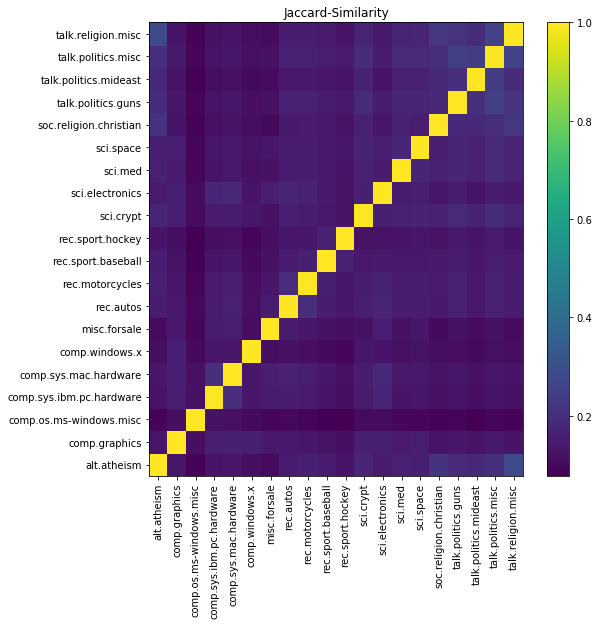

In [217]:
ploting(jaccard_final_dt,'Jaccard-Similarity')

Jaccard similarity shows poor similarity, I partly blame this on poor data. The kind of text I had after cleaning this data,needed some lemmatization and stemming. This could have given better results. One needs to note that the all these methods do not consider semantic similarity. Doc2Vec which projects documents in vector space is a fine method.

I have completed some methods to check similarity between groups and visualize them. I shall update this further to showcase some better findings.